## Continuous Bag Of Words (CBOW) Model

- CBOW is a method to **predict the target words from the surrounding context words (words before and after)**.

```markdown
# Example
sentence = "The quick brown fox jumps over the lazy dog"

# Input & Output
input | output
-------|-------
(quick The) (fox jumps) | brown
(brown quick) (jumps over) | fox
...
```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [2]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}

print(f"{len(vocab)=}")

len(vocab)=49


---
## Let's create CBOW data from the given text data with window size 2.

In [3]:

data = []

for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = [raw_text[i - j - 1] for j in range(CONTEXT_SIZE)] + [
        raw_text[i + j + 1] for j in range(CONTEXT_SIZE)
    ]
    target = raw_text[i]
    data.append((context, target))

print(f"{data[:5]=}")

data[:5]=[(['are', 'We', 'to', 'study'], 'about'), (['about', 'are', 'study', 'the'], 'to'), (['to', 'about', 'the', 'idea'], 'study'), (['study', 'to', 'idea', 'of'], 'the'), (['the', 'study', 'of', 'a'], 'idea')]


---

## Create Model

In [5]:
class CBOWModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        # multiply by context_size (bcoz we'll be sending in context_size words at a time, so the input to the linear layer will be context_size * embedding_dim)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [6]:
EMBEDDING_DIM = 10

losses = []
loss_function = nn.NLLLoss()

model = CBOWModel(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE*2) # context_size*2 bcoz we are sending in context_size words from the left and context_size words from the right
optimizer = optim.SGD(model.parameters(), lr=0.001)

/Users/Deependu/Library/Python/3.9/lib/python/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


---

## Train Model

100%|██████████| 100/100 [00:00<00:00, 106.98it/s]


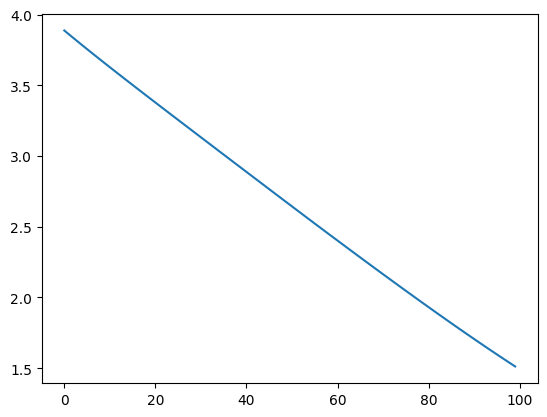

In [7]:
from tqdm import tqdm

no_of_epochs = 100

for epoch in tqdm(range(no_of_epochs)):
    total_loss = 0
    for context, target in data:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idx = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        optimizer.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idx)
        # print(f"{log_probs=}")
        # print(f"{word_to_ix[target]=}")

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(
            log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long)
        )

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()

    avg_loss = total_loss / len(data)
    losses.append(avg_loss)
    total_loss = 0

import matplotlib.pyplot as plt

plt.plot(losses, label="loss")

---

## Inspect Embeddings

In [9]:
# To get the embedding of a particular word, e.g. "beauty"
print(model.embeddings.weight[word_to_ix["about"]])

tensor([-0.3431,  0.9445, -0.5541,  0.8399,  1.7945, -0.1945,  0.5205, -1.8649,
        -2.9370, -0.5753], grad_fn=<SelectBackward0>)


In [10]:
print(model.embeddings.weight.size())

torch.Size([49, 10])


---

## Visualize the embeddings using **TensorBoard**

In [11]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("tensorboard/text-embedding-visualization")

writer.add_embedding(model.embeddings.weight, metadata=list(vocab))

#### Run the following command/cell to visualize the embeddings:

- visit `http://localhost:6006` in your web browser

```bash
tensorboard --logdir=tensorboard/text-embedding-visualization
```

In [12]:
!tensorboard --logdir=tensorboard/text-embedding-visualization

I0226 22:37:05.395128 6142111744 plugin.py:429] Monitor runs begin
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.15.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C
